# Final Machine Learning Pipeline

In [26]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from feature_engine.transformation import LogTransformer
from src.utils.preprocessors import OutliersTransformer, SquareRootTransformer
from sklearn.linear_model import LogisticRegression
from src.binary_classification.classification import evaluation
from sklearn import metrics
from src.utils import utils

In [3]:
DATASET_PATH = "../data/breast_cancer_wisconsin_diagnostic_dataset.csv"
COLUMNS_TO_DROP = ['id', 'Unnamed: 32']
TARGET = 'diagnosis'

In [4]:
df = pd.read_csv(DATASET_PATH)
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Separating the data into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(COLUMNS_TO_DROP + [TARGET], axis=1), # X
    df[TARGET], # y
    test_size=0.1, # Portion of dataset to allocate to test set.
    random_state=8, # Setting the seed for reproducibility.
    stratify=df[TARGET] # Ensures proportion of samples for each class will be preserved.
)

X_train.shape, X_test.shape

((512, 30), (57, 30))

## Target

In [6]:
y_train = y_train.map({'M':1,'B':0})
y_test = y_test.map({'M':1,'B':0})

## Configuration

In [15]:
# Outliers transformer config.
THRESHOLD = 4
LIMITS = 0.1

# Scaler config.
FEATURE_RANGE = (0, 1)

# Features selected.
FEATURES = ['concavity_mean',
            'concave points_mean',
            'area_se',
            'radius_worst',
            'texture_worst',
            'perimeter_worst',
            'area_worst',
            'smoothness_worst',
            'concavity_worst',
            'concave points_worst',
            'symmetry_worst']

# Variables to square root transform.
SQUARE_ROOT_VARS = [col_name for col_name
                    in X_train.columns[(X_train == 0).any()].tolist()
                    if col_name in FEATURES]

# Variables to log transform.
LOG_TRANSFORM_VARS = [col_name for col_name in X_train.columns \
                    if not col_name in SQUARE_ROOT_VARS and col_name in FEATURES]

# Model parameters.
MODEL_PARAMS = {'penalty': 'l2',
                'C': 1000,
                'solver': 'newton-cg',
                'max_iter': 10000,
                'random_state': 42}

In [16]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((512, 11), (57, 11))

## ML Pipeline

In [17]:
pipe = Pipeline([
    # Outliers.
    ('outliers_imputation', OutliersTransformer(
        variables=FEATURES,
        threshold=THRESHOLD,
        limits=LIMITS
    )),
    # Transformations.
    ('square_root', SquareRootTransformer(variables=SQUARE_ROOT_VARS)),
    ('log', LogTransformer(variables=LOG_TRANSFORM_VARS)),
    # Scaling.
    ('scaler', MinMaxScaler(feature_range=FEATURE_RANGE)),
    # Model.
    ('model', LogisticRegression(**MODEL_PARAMS)),    
])

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('outliers_imputation',
                 OutliersTransformer(limits=0.1, threshold=4,
                                     variables=['concavity_mean',
                                                'concave points_mean',
                                                'area_se', 'radius_worst',
                                                'texture_worst',
                                                'perimeter_worst', 'area_worst',
                                                'smoothness_worst',
                                                'concavity_worst',
                                                'concave points_worst',
                                                'symmetry_worst'])),
                ('square_root',
                 SquareRootTransformer(variables=['concavity_mean',
                                                  'concave points_mean',
                                                  'concavity_worst',
                                                  'concave points_worst'])),
                ('log',
                 LogTransformer(variables=['area_se', 'radius_worst',
                                           'texture_worst', 'perimeter_worst',
                                           'area_worst', 'smoothness_worst',
                                           'symmetry_worst'])),
                ('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=1000, max_iter=10000, random_state=42,
                                    solver='newton-cg'))])

### Evaluation

In [21]:
# Training set.

pred = pipe.predict(X_train)

print(evaluation(y_train, pred))

   accuracy  precision  recall      f1  auc_roc
0    0.9863     0.9842  0.9791  0.9816   0.9849


In [22]:
# Test set.

pred = pipe.predict(X_test)

print(evaluation(y_test, pred))

   accuracy  precision  recall    f1  auc_roc
0    0.9649        1.0  0.9048  0.95   0.9524


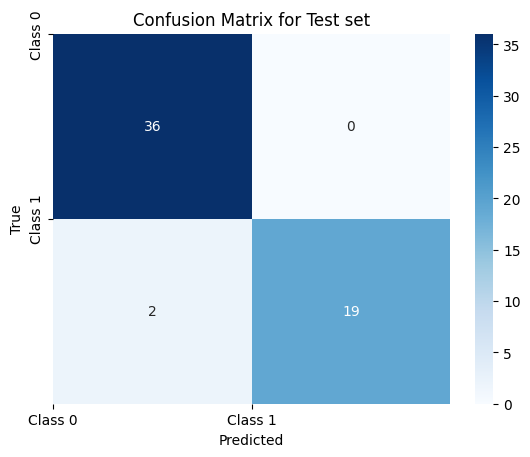

In [24]:
confusion_matrix = metrics.confusion_matrix(y_test,
                                            pred)
class_labels = ['Class 0', 'Class 1']

# Create a heatmap plot of the confusion matrix
utils.plot_confusion_matrix(confusion_matrix,
                            class_labels)

### Saving the pipeline.

In [27]:
joblib.dump(pipe, 'outputs/ML_pipe.joblib') 

['outputs/ML_pipe.joblib']